# <center> "Embedded" Lorenz'63 model </center>

Embedded Lorenz'63 model (eL63) is a $d$-dimension extension of Lorenz'63 (L63) model <a href="https://journals.ametsoc.org/jas/article/20/2/130/16956/Deterministic-Nonperiodic-Flow">(Lorenz, 1963)</a>. The purpose of eL63 is to better understrand numerical instabilities that are encountered when developing artificial neural network (ANN) based parameterization schemes for atmospheric models. 

L63 dynamics are given by :
\begin{equation}
  \begin{aligned}
    \dot{z}_1 & = \sigma (z_2 - z_1) \\
    \dot{z}_2 & = \rho z_1 - z_2 - z_1 z_3 \\
    \dot{z}_3 & = z_1 z_2 - \beta z_3.
  \end{aligned}
  \label{eq:L63} \tag{1}
\end{equation}
where parameters are set to : $\sigma=10,~\rho=28,~\beta=8/3$.


eL63 can be defined as an extension of L63 to dimension $d$ of state variable $\mathbf{X}$ living in "learning basis" $\mathcal{B}_X$. In practice, eL63 admits explicit dynamics in another subset of $\mathbb{R}^d$ called "Lorenz basis" and noted $\mathcal{B}_Z$. In $\mathcal{B}_Z$, L63 equatations (Eq. \ref{eq:L63}) are extended to dimension $d$ with restoring forces equations. Associated state variable $\mathbf{Z}$ evolves following eL63 equations : 
\begin{equation}
  \begin{aligned}
    \dot{z}_1 & = \sigma (z_2 - z_1) \\
    \dot{z}_2 & = \rho z_1 - z_2 - z_1 z_3 \\
    \dot{z}_3 & = z_1 z_2 - \beta z_3 \\
    \dot{z}_{j,j>3} & = -\kappa z_j,
  \end{aligned}
  \label{eq:eL63} \tag{2}
\end{equation}
where $\kappa>0$ and $\sigma=10,~\rho=28,~\beta=8/3$. The ANN only sees state variable $\mathbf{X}$ and thus learns to represent eL63 dynamics in $\mathcal{B}_X$.

The following notebook aims at illustrating learning of eL63 dynamics by a basic ANN (the architecture and learning parameters are the same for every ANN presented in this notebook). First section will focus on the learning of canonical L63 model, without rotation (i.e. in $\mathcal{B}_Z$). Second section will implement the learning from a single orbit. In third section, a learning sample will be built by Latin Hypercube Sampling (LHS) and learned by an ANN.

In [1]:
# -- Importations
import numpy as np
import sys
sys.path.append('utils_eL63/')
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# -- Importation from utils_eL63
from utils_eL63.eL63 import embeddedLorenz63
from utils_eL63.integrate import integrate_runge_kutta
from utils_eL63.ML_model import ML_model
from utils_eL63.utils import *

In the following, time will be expressed in *Model Time Units* (MTU), where 1 MTU = 100 timesteps = 100 integrations. Thus, the equivalent of an orbit of length 100 MTU is a sample of size 10,000.

## 1. Learning of L63 model
L63 model can be easily learnt by ANNs. The purpose of this section is to learn L63 time derivatives $\mathbf{\dot{Z}}=(\dot{z}_1, \dot{z}_2, \dot{z}_3)$ as a function $f$ of the state vector $\mathbf{Z}=(z_1, z_2, z_3)$ :
\begin{equation}
    \mathbf{\dot{Z}} = f(\mathbf{Z}).
    \label{eq:learning} \tag{3}
\end{equation}

Please note that in the section below, we will use `eL63` object without random projection; restricted to `d=3`, we recover L63 model. 

#### Setting up L63 model

In [2]:
# -- Defining L63 object.
ndim = 3          # L63 model can be seen as eL63 model with d=3.
aleamat = True    # Random choice for set B_X. Not important so far.

Nt = 11000        # Number of iterations for learning orbit. 1,000 first timesteps will be discarded.
dt = 0.01         # Value of time increment \Delta t for integration.

# -- Defining condition.
z0 = np.array([10, 5, 0])

# -- Definition of L63 object
dic_LZ = {'aleamat':aleamat, 'ndim':ndim, 'sigma':10., 'beta':8./3., 'rho':28., 'kappa':1.}
L63 = embeddedLorenz63(dic=dic_LZ)     # Creating L63 object.  
f = L63.tendencies()                   # L63 tendencies in f. 

# -- Getting a first orbit. 
tt, traj, tend = integrate_runge_kutta(f, t0=0., t=(Nt-1)*dt, dt=dt, ic=z0)

Z = (traj.T)[1000:]   # State vector time series or orbit.
dZ = (tend.T)[1000:]   # Time derivatives associated with Z.

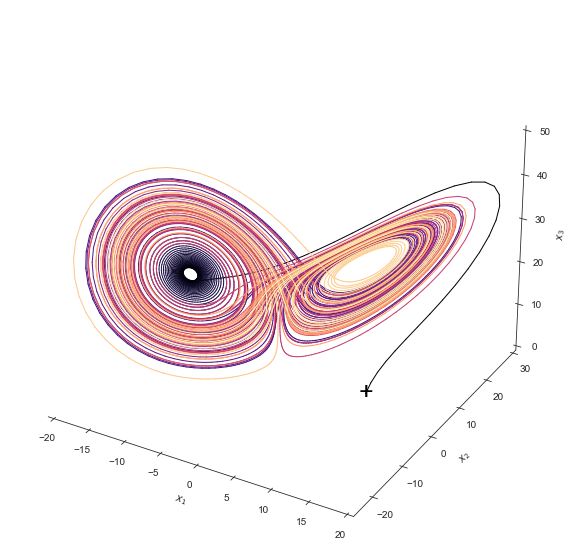

In [3]:
# -- Graphical representation of a L63 orbit. Starting point is represented by a black cross.
plot_3d_timeseries(traj.T, cmap="magma")

#### Building random train/test subsets from the learning orbit

In [4]:
# -- Building random train/test subsets
n_samples = 10000      # Total training samples n=10,000.
norm = True            # True if subsets to normalize.

# If subsets are normalized, their mean value =0 and standard derviation =1. 
if norm:
    mean_Z, mean_dZ = np.mean(Z, axis=0), np.mean(dZ, axis=0)
    std_Z, std_dZ = np.std(Z, axis=0), np.std(dZ, axis=0)

    Zn = (Z-mean_Z)/std_Z
    dZn = (dZ-mean_dZ)/std_dZ
    
    # Random train/test split.
    Z_train, Z_test, dZ_train, dZ_test = train_test_split(Zn, dZn, test_size=0.2, random_state=42)

else:
    # Random train/test split.
    Z_train, Z_test, dZ_train, dZ_test = train_test_split(Z, dZ, test_size=0.2, random_state=42)

#### Setting up ANN

In [5]:
# -- Setting up NN model
input_dim, out_dim = Z_train.shape[1], dZ_train.shape[1]
layers = [256] + 5*[128] + [64, 32]       # Layers with the number of nodes on each one.
epochs = 50                               # Number of learning epochs.

# -- Building ANN 
mm_dict = {'in_dim':input_dim, 'out_dim':out_dim, 'nlays':layers, 'epochs':epochs}
mm_L63 = ML_model(mm_dict)
mm_L63.build_model(input_dim, out_dim)

monitor = 'val_r2_score_keras'            # Monitored score during ANN fit.

# -- Model checkpoint : saving best model weights wrt "monitor" score.
ckpt = ModelCheckpoint("weights/weights-MLP-L63.h5",
        monitor=monitor, save_best_only=True, verbose=1, mode="max")

# -- Fitting model 
history = mm_L63.model.fit(Z_train, dZ_train, epochs=epochs,
        batch_size=32, verbose=1, validation_data=(Z_test, dZ_test), callbacks=[ckpt])

# -- Loading best ANN weights
mm_L63.model.load_weights("weights/weights-MLP-L63.h5")

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_data (InputLayer)          [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

Epoch 21/50
241/250 [===========================>..] - ETA: 0s - loss: 2.9787e-04 - r2_score_keras: 0.9997
Epoch 00021: val_r2_score_keras did not improve from 0.99980
250/250 [==============================] - 1s 4ms/step - loss: 2.9307e-04 - r2_score_keras: 0.9997 - val_loss: 1.9280e-04 - val_r2_score_keras: 0.9998
Epoch 22/50
247/250 [============================>.] - ETA: 0s - loss: 3.5041e-04 - r2_score_keras: 0.9996
Epoch 00022: val_r2_score_keras did not improve from 0.99980
250/250 [==============================] - 2s 7ms/step - loss: 3.5075e-04 - r2_score_keras: 0.9996 - val_loss: 3.8390e-04 - val_r2_score_keras: 0.9996
Epoch 23/50
247/250 [============================>.] - ETA: 0s - loss: 0.0017 - r2_score_keras: 0.9983
Epoch 00023: val_r2_score_keras did not improve from 0.99980
250/250 [==============================] - 2s 6ms/step - loss: 0.0017 - r2_score_keras: 0.9983 - val_loss: 0.0021 - val_r2_score_keras: 0.9979
Epoch 24/50
250/250 [==============================] - 

Epoch 47/50
238/250 [===========================>..] - ETA: 0s - loss: 2.7662e-04 - r2_score_keras: 0.9997
Epoch 00047: val_r2_score_keras did not improve from 0.99981
250/250 [==============================] - 1s 4ms/step - loss: 2.8341e-04 - r2_score_keras: 0.9997 - val_loss: 4.7146e-04 - val_r2_score_keras: 0.9995
Epoch 48/50
244/250 [============================>.] - ETA: 0s - loss: 8.8331e-04 - r2_score_keras: 0.9991
Epoch 00048: val_r2_score_keras did not improve from 0.99981
250/250 [==============================] - 1s 4ms/step - loss: 9.0685e-04 - r2_score_keras: 0.9990 - val_loss: 6.6743e-04 - val_r2_score_keras: 0.9993
Epoch 49/50
236/250 [===========================>..] - ETA: 0s - loss: 0.0024 - r2_score_keras: 0.9975
Epoch 00049: val_r2_score_keras did not improve from 0.99981
250/250 [==============================] - 1s 3ms/step - loss: 0.0023 - r2_score_keras: 0.9976 - val_loss: 7.9216e-04 - val_r2_score_keras: 0.9992
Epoch 50/50
236/250 [===========================>..

#### Evaluation
The performance of the ANN model is assessed by integrating predicted time derivatives over `Nt_snapshots`. The result will be compared with direct integration of L63 equations from the same initial condition `z0`.

In [6]:
# -- Setting up evaluation - parameters.
n_snapshots = 1                 # Number of initial conditions.
z0 = np.array([10,15,0])        # Initial condition value.
Nt_snapshots = 10000            # Length of integration, in timesteps.

In [7]:
%%time
# -- Integration of L63 equations.
# -- Computing validation orbit from z0. 
_, traj, _ = integrate_runge_kutta(f, t0=0., t=(Nt_snapshots-1)*dt, dt=dt, ic=z0)
Z_val = traj.T

CPU times: user 2.15 s, sys: 33.8 ms, total: 2.19 s
Wall time: 2.5 s


The execution of the cell below can may take some time, all the more so that the number of validation timestep `Nt_snapshots` is important.

In [8]:
%%time
# -- Integration of ANN predicted time derivatives.

# "De-normalizing" if the ANN learnt from normalized data.
if norm :
    mm_L63.norms = [mean_Z, mean_dZ, std_Z, std_dZ]
    
f_hat = mm_L63.tendencies()    # Getting time derivatives to integrate.

# -- Computing validation orbit from z0.
_, traj, _ = integrate_runge_kutta(f_hat, t0=0., t=(Nt_snapshots-1)*dt, dt=dt, ic=z0.reshape(1, -1))
Z_ML_val = traj.T

CPU times: user 3min 10s, sys: 14.6 s, total: 3min 25s
Wall time: 3min 32s


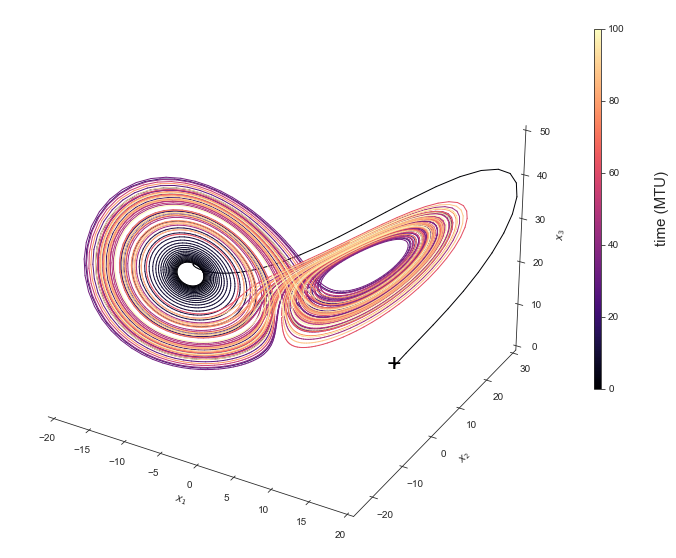

In [9]:
# -- Validation orbit : integration of eL63 equations
plot_3d_timeseries(Z_val, cmap="magma", save=False, cbar=True)

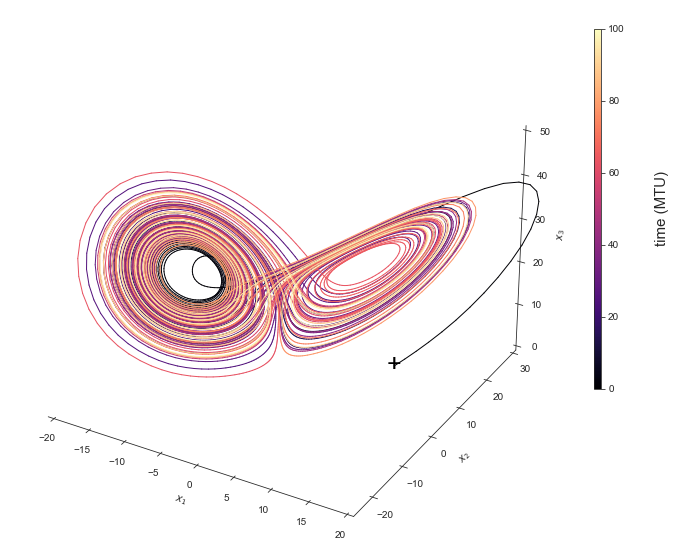

In [10]:
# -- Validation orbit : integration of ANN predicted tendencies
plot_3d_timeseries(Z_ML_val, cmap="magma", save=False, cbar=True)

The ANN model does not manifest any instability over a long integration of 10,000 timesteps. The ANN might be off for the first timesteps, but it does not mean that L63 dynamics has not been learned accurately enough. Transitory phase has been removed from the learning orbit.

## 2. Learning eL63 dynamics from a single orbit - example for $d=10$

We focus now on learning eL63 model when $d=10$, from a single orbit. The following section is organized as previously. As opposed to learning L63 dynamics, learning of eL63 will be performed in $\mathcal{B}_X$ (in the case of L63, learning was performed in $\mathcal{B}_Z$).

The value of $\kappa$ is set to 1.

#### Setting up L63 model with $d=10$

In [11]:
# -- Defining L63 object.
ndim = 10         # L63 model can be seen as eL63 model with d=3.
aleamat = True    # Random choice for set B_X. Not important so far.

Nt = 11000        # Number of iterations for learning orbit. 1,000 first timesteps will be discarded.
dt = 0.01         # Value of time increment \Delta t for integration.

# -- Random initial condition for initial run.
z0 = (np.random.random(ndim)-0.5)*10
z0[:3] = [10, 5, 0]

# -- Definition of L63 object
dic_LZ = {'aleamat':aleamat, 'ndim':ndim, 'sigma':10., 'beta':8./3., 'rho':28., 'kappa':1.}
eL63 = embeddedLorenz63(dic=dic_LZ)     # Creating L63 object.  
f = eL63.tendencies()                   # L63 tendencies in f. 

# -- Getting a first orbit. 
tt, traj, tend = integrate_runge_kutta(f, t0=0., t=(Nt-1)*dt, dt=dt, ic=z0)

# -- Orbit seen in "Lorenz basis" B_Z
Z = (traj.T)[1000:]    # State vector time series or orbit.
dZ = (tend.T)[1000:]   # Time derivatives associated with Z.

# -- Orbit seen in "Learning basis" B_X
X  = eL63.BZ_to_BX(Z)    # State vector time series or orbit.
dX = eL63.BZ_to_BX(dZ)   # Time derivatives associated with X.

An example of eL63 orbit where $d=10$, in "learning basis" $\mathcal{B}_X$, is represented in the following panel.

Text(0.5, 0.98, '$\\mathbf{X}(t)$ seen in $\\mathcal{B}_X$')

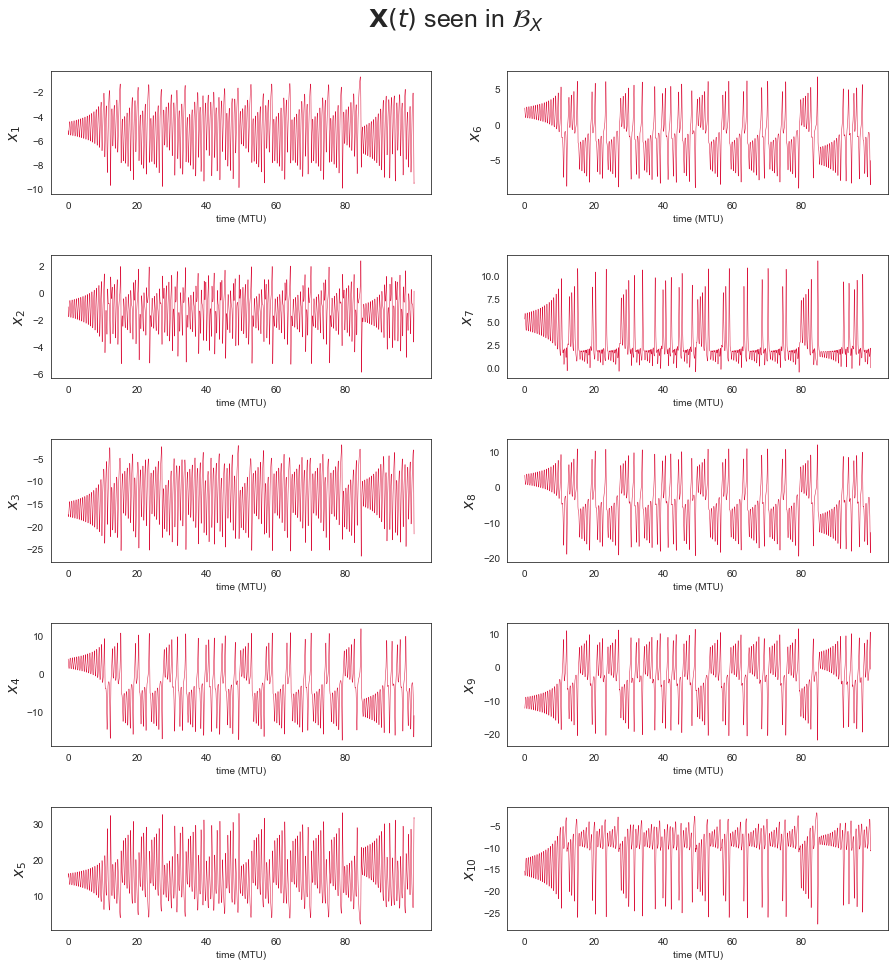

In [15]:
nrows, ncols = 5, 2
ind_s, ind_e = 0, -1

sns.set_style("white")
# Plotting X in B_X
fig, ax = plt.subplots(nrows, ncols, figsize=(15,15))
plt.subplots_adjust(hspace=0.5, top=0.92)
for i in range(nrows) :
    ax[i,0].plot(X[ind_s:ind_e,i], color="crimson", lw=0.5)
    ax[i,1].plot(X[ind_s:ind_e,i+5], color="crimson", lw=0.5)
    ax[i,0].set_xticks(np.arange(0,10,2)*1000)
    ax[i,0].set_xticklabels(np.arange(0,100,20))
    ax[i,0].set_xlabel("time (MTU)")
    ax[i,1].set_xticks(np.arange(0,10,2)*1000)
    ax[i,1].set_xticklabels(np.arange(0,100,20))
    ax[i,1].set_xlabel("time (MTU)")
    ax[i,0].set_ylabel("$x_{%d}$" % (i+1), fontsize=15)
    ax[i,1].set_ylabel("$x_{%d}$" % (i+6), fontsize=15)
plt.suptitle("$\mathbf{X}(t)$ seen in $\mathcal{B}_X$", fontsize=25)

#### Building random train/test subsets from the learning orbit

In [16]:
n_samples = 10000      # Total training samples n=10,000.
norm = True            # True if subsets to normalize.

# If subsets are normalized, their mean value =0 and standard derviation =1. 
if norm:
    mean_X, mean_dX = np.mean(X, axis=0), np.mean(dX, axis=0)
    std_X, std_dX = np.std(X, axis=0), np.std(dX, axis=0)

    Xn = (X-mean_X)/std_X
    dXn = (dX-mean_dX)/std_dX
    
    # Random train/test split.
    X_train, X_test, dX_train, dX_test = train_test_split(Xn, dXn, test_size=0.2, random_state=42)

else:
    # Random train/test split.
    X_train, X_test, dX_train, dX_test = train_test_split(X, dX, test_size=0.2, random_state=42)

#### Setting up ANN

The resulting function learned from the single training orbit, according to Eq. (3), will be noted $\hat{f}^{orb}$.

In [17]:
# -- Setting up NN model
input_dim, out_dim = X_train.shape[1], dX_train.shape[1]
layers = [256] + 5*[128] + [64, 32]       # Layers with the number of nodes on each one.
epochs = 50                               # Number of learning epochs.

# -- Building ANN 
mm_dict = {'in_dim':input_dim, 'out_dim':out_dim, 'nlays':layers, 'epochs':epochs}
mm_orb = ML_model(mm_dict)
mm_orb.build_model(input_dim, out_dim)

monitor = 'val_r2_score_keras'            # Monitored score during ANN fit.

# -- Model checkpoint : saving best model weights wrt "monitor" score.
ckpt = ModelCheckpoint("weights/weights-MLP-eL63--d"+str(L63.ndim)+".h5",
        monitor=monitor, save_best_only=True, verbose=1, mode="max")

# -- Fitting model 
history = mm_orb.model.fit(X_train, dX_train, epochs=epochs,
        batch_size=32, verbose=1, validation_data=(X_test, dX_test), callbacks=[ckpt])

# -- Loading best ANN weights
mm_orb.model.load_weights("weights/weights-MLP-eL63--d"+str(L63.ndim)+".h5")

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_data (InputLayer)          [(None, 10)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2816      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 128)              

Epoch 22/50
245/250 [============================>.] - ETA: 0s - loss: 0.0071 - r2_score_keras: 0.9926
Epoch 00022: val_r2_score_keras did not improve from 0.99928
250/250 [==============================] - 1s 4ms/step - loss: 0.0070 - r2_score_keras: 0.9926 - val_loss: 0.0076 - val_r2_score_keras: 0.9920
Epoch 23/50
249/250 [============================>.] - ETA: 0s - loss: 0.0025 - r2_score_keras: 0.9974
Epoch 00023: val_r2_score_keras did not improve from 0.99928
250/250 [==============================] - 1s 4ms/step - loss: 0.0025 - r2_score_keras: 0.9974 - val_loss: 7.6673e-04 - val_r2_score_keras: 0.9992
Epoch 24/50
235/250 [===========================>..] - ETA: 0s - loss: 9.5764e-04 - r2_score_keras: 0.9990
Epoch 00024: val_r2_score_keras did not improve from 0.99928
250/250 [==============================] - 1s 4ms/step - loss: 0.0011 - r2_score_keras: 0.9988 - val_loss: 0.0034 - val_r2_score_keras: 0.9965
Epoch 25/50
250/250 [==============================] - ETA: 0s - loss: 

Epoch 48/50
237/250 [===========================>..] - ETA: 0s - loss: 0.0057 - r2_score_keras: 0.9940
Epoch 00048: val_r2_score_keras did not improve from 0.99976
250/250 [==============================] - 1s 3ms/step - loss: 0.0055 - r2_score_keras: 0.9942 - val_loss: 6.6540e-04 - val_r2_score_keras: 0.9993
Epoch 49/50
236/250 [===========================>..] - ETA: 0s - loss: 0.0027 - r2_score_keras: 0.9971
Epoch 00049: val_r2_score_keras did not improve from 0.99976
250/250 [==============================] - 1s 3ms/step - loss: 0.0026 - r2_score_keras: 0.9973 - val_loss: 8.5786e-04 - val_r2_score_keras: 0.9991
Epoch 50/50
235/250 [===========================>..] - ETA: 0s - loss: 6.8733e-04 - r2_score_keras: 0.9993
Epoch 00050: val_r2_score_keras did not improve from 0.99976
250/250 [==============================] - 1s 3ms/step - loss: 6.7459e-04 - r2_score_keras: 0.9993 - val_loss: 3.3650e-04 - val_r2_score_keras: 0.9996


#### Evaluation
The performance of the ANN model is assessed by integrating predicted time derivatives over `Nt_snapshots`. The result will be compared with direct integration of L63 equations from 100 values of initial condition `x0`, first generated in $\mathcal{B}_Z$.

In [18]:
# -- Setting up evaluation - parameters.
n_snapshots = 100                # Number of initial conditions.
Nt_snapshots = 10000             # Length of integration, in timesteps.

# -- Getting n_snapshots random initial conditions.
np.random.seed(42)
z0 = np.random.random((n_snapshots, ndim))
a = np.r_[np.array([-20, -20, 0]), -5*np.ones(ndim-3)]
b = np.r_[np.array([20, 20, 40]), 5*np.ones(ndim-3)]
z0 = (b - a)*z0 + a

x0 = eL63.BZ_to_BX(z0)         # Initial condition value, in B_Z. 

The execution of the cell below can may take some time, all the more so that the number of validation timestep `Nt_snapshots` is important.

In [19]:
%%time
# -- Integration of L63 equations.

# -- Computing validation orbit from z0 in B_Z.
_, traj, _ = integrate_runge_kutta(f, t0=0., t=(Nt_snapshots-1)*dt, dt=dt, ic=z0)

if n_snapshots > 1:
    # -- Save last iteration.
    Z_orb = np.swapaxes(traj, 1,2)
else :
    # -- Only 1 trajectory.
    Z_orb = traj.T

CPU times: user 3min 28s, sys: 2.65 s, total: 3min 30s
Wall time: 3min 44s


In [20]:
%%time
# -- Integration of ANN predicted time derivatives.

# "De-normalizing" if the ANN learnt from normalized data.
mm_orb.norms = [mean_X, mean_dX, std_X, std_dX]

f_hat = mm_orb.tendencies()       # Getting time derivatives to integrate.

# -- Computing validation orbit from x0 in B_X.
_, traj, _ = integrate_runge_kutta(f_hat, t0=0., t=(Nt_snapshots-1)*dt, dt=dt, ic=x0.reshape(1, -1))

if n_snapshots > 1:
    X_snapshots = np.reshape(traj, (n_snapshots, eL63.ndim, -1))
    # -- Save last iteration.
    X_ML_orb = X_snapshots
else:
    # -- only 1 trajectory
    X_ML_orb = traj.T

# -- transfer from BX to BZ
Z_ML_orb = eL63.BX_to_BZ(X_ML_orb)
X_ML_orb = np.swapaxes(X_ML_orb, 1,2)

CPU times: user 4min 49s, sys: 30.8 s, total: 5min 19s
Wall time: 4min 52s


Stability of the resulting model can be evaluated in $\mathcal{B}_X$. Given $(X)_N=(x_1, x_2, ..., x_d)_N$ the orbit from which train and test dataset has been built, one can define intermediate variables $m_i, M_i$ and $\Delta$ by :
\begin{equation}
  \begin{aligned}
    \forall~~ 1 \leq i \leq d, ~m_i,M_i & = \min~(x_i)_N,\max~(x_i)_N \\
    \Delta_i & = M_i - m_i
  \end{aligned}
\end{equation}

An ANN model validation orbit of length $N \geq 10,000$ timesteps is considered stable if it verifies **stability criterion** that can be expressed as follows, for any validation orbit $(\mathbf{X}^{orb})_N = (x_1^{orb}, x_2^{orb}, ..., x_d^{orb})_N$ : 
\begin{equation}
  \begin{aligned}
        \forall ~0<i\leq d,~\forall~x_i \in (x_i^{orb})_N,~~ m_i-a\Delta_i \leq x_i \leq M_i+a\Delta_i,
  \end{aligned}
  \label{eq:stab} \tag{4}
\end{equation}
where $a=3$. 

In [21]:
# -- Getting minimal & maximal values over training dataset : divergence cube
# X is the learning orbit. These values will be saved for the LHS model validation as well. 
a = 3
delta = np.max(X, axis=(0)) - np.min(X, axis=(0,1))
mini = np.min(X, axis=(0)) - a*delta
maxi = np.max(X, axis=(0)) + a*delta

In [26]:
# -- Testing stability of ANN predicted orbits
list_divergence = divergence(X_ML_orb, mini, maxi)

print("Unstable initial conditions : \n ")
print(list_divergence)

Unstable initial conditions : 
 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 65, 67, 68, 70, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 95, 96, 98, 99]


Part of resulting validation orbits is unstable, meaning stability criteria could not been verified for some of the initial conditions. 

In [36]:
ind = np.random.choice(list_divergence)
print("Random testing index : %d." %ind)

Random testing index : 74.


To compare fit of $\hat{f}^{orb}$ through the accuracy of predicted orbit, the following cells will plot an orbit obtained by integration of $\hat{f}^{orb}$ with an orbit obtained by direct integration of eL63 equations (Eq. (2)).

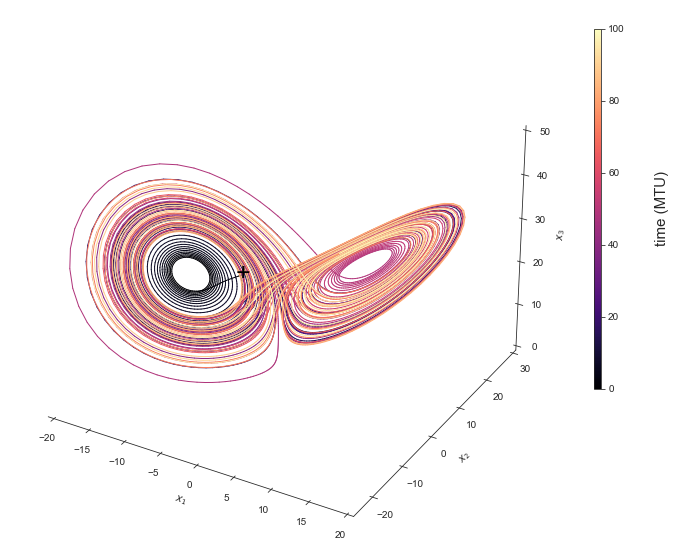

In [38]:
# -- Validation orbit : integration of eL63 equations
plot_3d_timeseries(Z_orb[ind], cmap="magma", save=False, cbar=True)

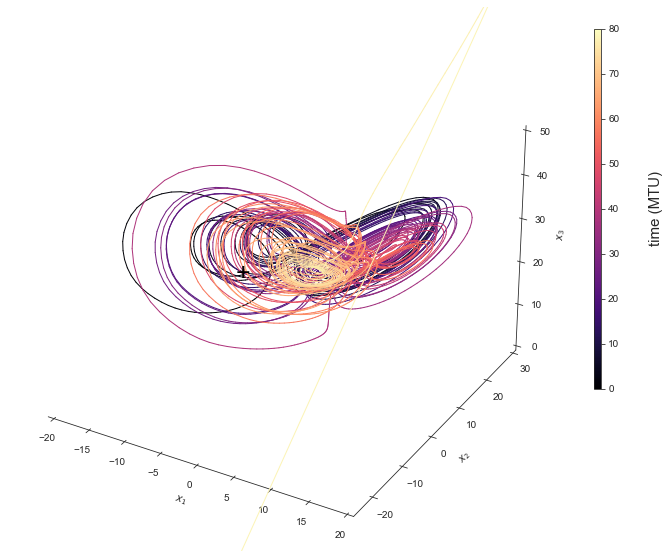

In [37]:
# -- Validation orbit : integration of eL63 equations
plot_3d_timeseries(Z_ML_orb[ind,:8000], cmap="magma", save=False, cbar=True)

## 3. Learning from a dataset generated by Latin Hypercube Sampling (LHS)

A single orbit as a learning set can be seen as degenerated ; thus instability issues can be seen as an **out-of-distribution** problem. Here we test the idea of learning from a training dataset including a region around eL63 attractors, with Latin Hypercube Sampling (LHS). 

To compare learning from different datasets (i.e. a single orbit or LHS sample), the ANN architecture will remain the same as in the previous section. LHS sample size will also match training orbit length of $N=10,000$. Validation orbits will be generated from the same initial conditions than in the previous section. 

#### Building random train/test subsets from an LHS sample

In [39]:
n_samples = 10000      # Total training samples n=10,000.
norm = True            # True if subsets to normalize.

# -- Creating LHS learning dataset in B_X
X_lhs, dX_lhs = eL63.generate_LHS_sampling(X, n_samples=n_samples)

# If subsets are normalized, their mean value =0 and standard derviation =1. 
norm = True     # True if normalized subsets
if norm:
    mean_Xlhs, mean_dXlhs = np.mean(X_lhs, axis=0), np.mean(dX_lhs, axis=0)
    std_Xlhs, std_dXlhs = np.std(X_lhs, axis=0), np.std(dX_lhs, axis=0)

    X_lhsn = (X_lhs-mean_Xlhs)/std_Xlhs
    dX_lhsn = (dX_lhs-mean_dXlhs)/std_dXlhs
    
    # Random train/test split.
    X_train_lhs, X_test_lhs, dX_train_lhs, dX_test_lhs = train_test_split(X_lhsn, dX_lhsn, test_size=0.2, 
                                                                          random_state=42)

else:
    # Random train/test split.
    X_train_lhs, X_test_lhs, dX_train_lhs, dX_test_lhs = train_test_split(X_lhs, dX_lhs, test_size=0.2, 
                                                                          random_state=42)

As shown below, the LHS training sample also explores a region around eL63 attractors in $\mathcal{B}_Z$. 

In [40]:
from IPython.display import IFrame
IFrame(src='LHS_orb.html', width=900, height=600)

#### Setting up ANN

eL63 dynamics learned from an LHS generated sample will build function $\hat{f}^{LHS}$ that will be compared with $\hat{f}^{orb}$.

In [41]:
# -- Setting up NN model
np.random.seed(42)
input_dim, out_dim = X_train_lhs.shape[1], dX_train_lhs.shape[1]
layers = [256] + 5*[128] + [64, 32]       # Layers with the number of nodes on each one.
epochs = 50                               # Number of learning epochs.

# -- Building ANN 
mm_dict = {'in_dim':input_dim, 'out_dim':out_dim, 'nlays':layers, 'epochs':epochs}
mm_lhs = ML_model(mm_dict)
mm_lhs.build_model(input_dim, out_dim)

monitor = 'val_r2_score_keras'            # Monitored score during ANN fit.

# -- Model checkpoint : saving best model weights wrt "monitor" score.
ckpt = ModelCheckpoint("weights/weights-MLP-eL63--d"+str(L63.ndim)+"-lhs.h5",
        monitor=monitor, save_best_only=True, verbose=1, mode="max")

# -- Fitting model 
history = mm_lhs.model.fit(X_train_lhs, dX_train_lhs, epochs=epochs,
        batch_size=32, verbose=1, validation_data=(X_test_lhs, dX_test_lhs), callbacks=[ckpt])

# -- Loading best ANN weights
mm_lhs.model.load_weights("weights/weights-MLP-eL63--d"+str(L63.ndim)+"-lhs.h5")

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_data (InputLayer)          [(None, 10)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               2816      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 128)              

250/250 [==============================] - 1s 5ms/step - loss: 0.0044 - r2_score_keras: 0.9954 - val_loss: 0.0027 - val_r2_score_keras: 0.9971
Epoch 21/50
241/250 [===========================>..] - ETA: 0s - loss: 0.0031 - r2_score_keras: 0.9967
Epoch 00021: val_r2_score_keras did not improve from 0.99714
250/250 [==============================] - 1s 5ms/step - loss: 0.0032 - r2_score_keras: 0.9967 - val_loss: 0.0052 - val_r2_score_keras: 0.9945
Epoch 22/50
237/250 [===========================>..] - ETA: 0s - loss: 0.0055 - r2_score_keras: 0.9943
Epoch 00022: val_r2_score_keras did not improve from 0.99714
250/250 [==============================] - 1s 5ms/step - loss: 0.0054 - r2_score_keras: 0.9943 - val_loss: 0.0052 - val_r2_score_keras: 0.9945
Epoch 23/50
243/250 [============================>.] - ETA: 0s - loss: 0.0057 - r2_score_keras: 0.9940
Epoch 00023: val_r2_score_keras did not improve from 0.99714
250/250 [==============================] - 1s 5ms/step - loss: 0.0057 - r2_scor

243/250 [============================>.] - ETA: 0s - loss: 0.0066 - r2_score_keras: 0.9932
Epoch 00047: val_r2_score_keras did not improve from 0.99771
250/250 [==============================] - 1s 5ms/step - loss: 0.0066 - r2_score_keras: 0.9932 - val_loss: 0.0061 - val_r2_score_keras: 0.9936
Epoch 48/50
247/250 [============================>.] - ETA: 0s - loss: 0.0030 - r2_score_keras: 0.9968
Epoch 00048: val_r2_score_keras did not improve from 0.99771
250/250 [==============================] - 1s 4ms/step - loss: 0.0030 - r2_score_keras: 0.9968 - val_loss: 0.0039 - val_r2_score_keras: 0.9959
Epoch 49/50
235/250 [===========================>..] - ETA: 0s - loss: 0.0023 - r2_score_keras: 0.9976
Epoch 00049: val_r2_score_keras did not improve from 0.99771
250/250 [==============================] - 1s 4ms/step - loss: 0.0024 - r2_score_keras: 0.9975 - val_loss: 0.0030 - val_r2_score_keras: 0.9969
Epoch 50/50
246/250 [============================>.] - ETA: 0s - loss: 0.0030 - r2_score_ke

R2 scores associated with $\hat{f}^{LHS}$ are slightly below those of $\hat{f}^{orb}$ during fitting. In fact, this is not surprising as the region of $\mathcal{B}_X$ covered by $\hat{f}^{LHS}$ is greater than the single orbit from which $\hat{f}^{orb}$ has learned eL63 dynamics.

#### Evaluation 

The ANN model that has learned eL63 dynamics from an LHS generated sample is evaluated the same way than the ANN that learned from a single orbit. An orbit of length $N_{val}=100$ MTU or 10,000 timesteps (variable `Nt_snapshots`) is generated for a given number of initial conditions. Initial conditions are the same for evaluation of both models.

The execution of the following cell may take some time. 

In [42]:
%%time
# -- Integration of ANN predicted time derivatives.

# "De-normalizing" if the ANN learnt from normalized data.
mm_lhs.norms = [mean_Xlhs, mean_dXlhs, std_Xlhs, std_dXlhs]

f_hat = mm_lhs.tendencies()       # Getting time derivatives to integrate.

# -- Computing validation orbit from x0.
_, traj, _ = integrate_runge_kutta(f_hat, t0=0., t=(Nt_snapshots-1)*dt, dt=dt, ic=x0.reshape(1, -1))

if n_snapshots > 1:
    X_snapshots = np.reshape(traj, (n_snapshots, eL63.ndim, -1))
    # -- Save last iteration.
    X_ML_lhs = X_snapshots
else:
    # -- only 1 trajectory
    X_ML_lhs = traj.T

# -- transfer from B_X to B_Z
Z_ML_lhs = eL63.BX_to_BZ(X_ML_lhs)
X_ML_lhs = np.swapaxes(X_ML_lhs, 1,2)

CPU times: user 4min 54s, sys: 31.2 s, total: 5min 26s
Wall time: 5min 12s


Stability of $\hat{f}^{LHS}$ can be evaluated and compared with $\hat{f}^{orb}$, by using the stability criteria defined by Eq. (4) and implemented in Section 2.

In [43]:
# -- Testing stability of ANN predicted orbits
list_divergence_lhs = divergence(X_ML_lhs, mini, maxi)

print("Unstable initial conditions : \n")

print(list_divergence_lhs)

Unstable initial conditions : 

[]


None of the 100 random initial conditions results in a diverging orbit. To compare fit of $\hat{f}^{LHS}$ through the accuracy of predicted orbit, the following cells will plot an orbit obtained by integration of $\hat{f}^{LHS}$ with an orbit obtained by direct integration of eL63 equations (Eq. (2)).

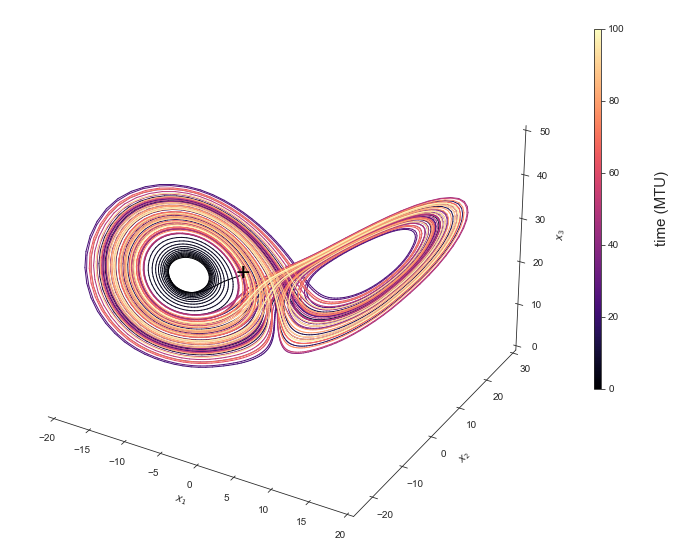

In [44]:
# -- Validation orbit : integration of eL63 equations
plot_3d_timeseries(Z_ML_lhs[ind], cmap="magma", save=False, cbar=True)

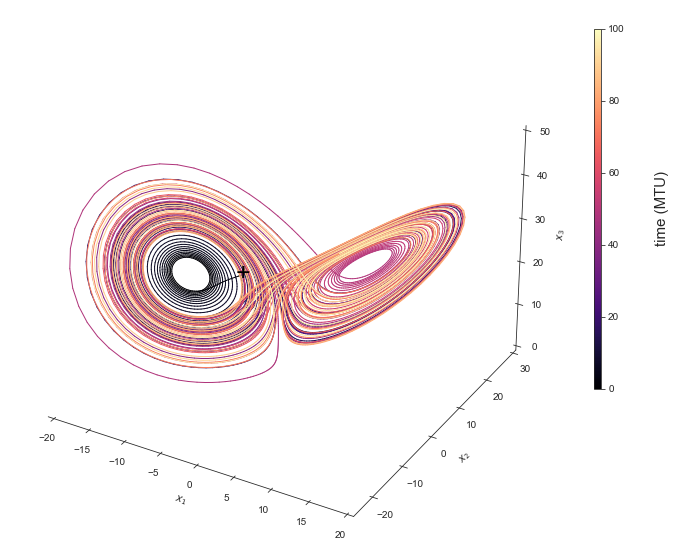

In [45]:
# -- Validation orbit : integration of eL63 equations
plot_3d_timeseries(Z_orb[ind], cmap="magma", save=False, cbar=True)

When $d=10$, learning from an LHS sample resulted in a stable ANN model $\hat{f}^{LHS}$ as opposed to $\hat{f}^{orb}$ obtained when the ANN learned eL63 dynamics from a single orbit. This underlies the importance of learning sample regarding the stability of the subsequent ANN-based model $\hat{f}$.